In [1]:
import numpy as np
import pylab as pl
import arrayfire as af
import h5py
af.set_backend("cpu")
%matplotlib inline

In [2]:
pl.rcParams['figure.figsize']  = 12, 7.5
pl.rcParams['lines.linewidth'] = 1.5
pl.rcParams['font.family']     = 'serif'
pl.rcParams['font.weight']     = 'bold'
pl.rcParams['font.size']       = 20  
pl.rcParams['font.sans-serif'] = 'serif'
pl.rcParams['text.usetex']     = True
pl.rcParams['axes.linewidth']  = 1.5
pl.rcParams['axes.titlesize']  = 'medium'
pl.rcParams['axes.labelsize']  = 'medium'

pl.rcParams['xtick.major.size'] = 8     
pl.rcParams['xtick.minor.size'] = 4     
pl.rcParams['xtick.major.pad']  = 8     
pl.rcParams['xtick.minor.pad']  = 8     
pl.rcParams['xtick.color']      = 'k'     
pl.rcParams['xtick.labelsize']  = 'medium'
pl.rcParams['xtick.direction']  = 'in'    

pl.rcParams['ytick.major.size'] = 8     
pl.rcParams['ytick.minor.size'] = 4     
pl.rcParams['ytick.major.pad']  = 8     
pl.rcParams['ytick.minor.pad']  = 8     
pl.rcParams['ytick.color']      = 'k'     
pl.rcParams['ytick.labelsize']  = 'medium'
pl.rcParams['ytick.direction']  = 'in'  

pl.rcParams['image.cmap']  = 'jet'
pl.rcParams['savefig.dpi'] = 300

In [3]:
# Setting velocity and spatial grid points
N_positions = 256
ghost_zones = 3
N_velocity  = 1001

In [4]:
# Boundaries of domain
left_boundary  = 0
right_boundary = 1.0
length         = right_boundary - left_boundary

In [5]:
# Setting mass of the particle, boltzmann-constant
mass_particle      = 1.0
boltzmann_constant = 1.0
charge_particle    = -10.0

In [6]:
# Scattering time scale
tau   = np.inf #0.01
# Magnitude of maximum velocity
v_max = 10

In [7]:
# Setting the parameters for time here
N_t        = 500
final_time = 1.0
dt         = final_time/N_t
time_array = np.linspace(dt, final_time, N_t)

In [8]:
# Setting up of spatial and velocity grids:
x  = np.linspace(left_boundary, right_boundary, N_positions)
dx = x[1] - x[0]

In [9]:
# Obtaining the coordinates for the ghost-zones:
x_ghost_left  = np.linspace(-(ghost_zones)*dx + left_boundary, left_boundary - dx, ghost_zones)
x_ghost_right = np.linspace(right_boundary + dx, right_boundary + ghost_zones*dx , ghost_zones)

In [10]:
# Combining them to obtain the entire spatial grid
x  = np.concatenate([x_ghost_left, x, x_ghost_right])

In [11]:
# Obtaining the velocity grid
v  = np.linspace(-v_max, v_max, N_velocity)
x  = af.Array.as_type(af.to_array(x), af.Dtype.f64)
v  = af.Array.as_type(af.to_array(v), af.Dtype.f64)

In [12]:
# Conversion to allow for easy vectorization
x = af.tile(x, 1, N_velocity)
v = af.tile(af.reorder(v), N_positions + 2*ghost_zones, 1)

In [13]:
# NOTE that all numerical integration definitions need to be changed
def calculate_density(f, v):
    deltav           = af.sum(v[0, 1]-v[0, 0])
    value_of_density = af.sum(f, 1)*deltav
    
    value_of_density = af.Array.as_type(value_of_density, af.Dtype.f64)
    
    af.eval(value_of_density)
    
    return(value_of_density)

In [14]:
def f_interp(dt, x, v, f):

    x_new     = x - 0.5*v*dt
    x_new     = af.Array.as_type(x_new, af.Dtype.f64)
    step_size = af.sum(x[1,0] - x[0,0])
    
    f_interp  = af.constant(0, N_positions + 2*ghost_zones, N_velocity)
    f_interp  = af.Array.as_type(f_interp, af.Dtype.f64)
    
    # Interpolating:
    
    x_temp = x_new[ghost_zones:-ghost_zones, :]
    
    while(af.sum(x_temp<left_boundary)!=0):
        x_temp = af.select(x_temp<left_boundary,
                           x_temp + length,
                           x_temp
                          )
        
    while(af.sum(x_temp>right_boundary)!=0):
        x_temp = af.select(x_temp>right_boundary,
                           x_temp - length,
                           x_temp
                          )

    x_temp        = af.Array.as_type(x_temp, af.Dtype.f64)
    
    x_interpolant = x_temp/step_size + ghost_zones
    
    x_interpolant = af.Array.as_type(x_interpolant, af.Dtype.f64)
    f             = af.Array.as_type(f, af.Dtype.f64)
    
    f_interp[ghost_zones:-ghost_zones, :] = af.approx1(f, x_interpolant,\
                                                       af.INTERP.CUBIC_SPLINE
                                                      )
#     pl.contourf(np.array(x[3:-3]), np.array(v[3:-3]), np.array(f_current[3:-3] - f_background[3:-3]), 100)
#     pl.colorbar()
#     pl.xlabel('$x$')
#     pl.ylabel('$v$')
#     pl.title('Time = ' + str(t0))
#     pl.savefig('images/' + "%04d"%time_index + '.png', dpi = 300)
#     pl.clf()
    f_interp          = af.Array.as_type(f_interp, af.Dtype.f64)
    
    af.eval(f_interp)
    return f_interp

In [15]:
def f_interp_v(dt, x, v, f, E):
    v_new     = v - charge_particle * dt * af.tile(E, 1, N_velocity)
    v_new     = af.Array.as_type(v_new, af.Dtype.f64)
    step_size = af.sum(v[0,1] - v[0,0])
    
    # Interpolating:
       
    v_interpolant = (v_new + v_max)/step_size
    v_interpolant = af.Array.as_type(v_interpolant, af.Dtype.f64)
    f             = af.Array.as_type(f, af.Dtype.f64)
    
    f_interp      = af.approx1(af.Array.as_type(af.reorder(f), af.Dtype.f64),\
                               af.Array.as_type(af.reorder(v_interpolant), af.Dtype.f64),\
                               af.INTERP.CUBIC_SPLINE
                              )
    
    f_interp          = af.Array.as_type(f_interp, af.Dtype.f64)
    f_interp          = af.reorder(f_interp)
    f_interp          = af.Array.as_type(f_interp, af.Dtype.f64)
    
    af.eval(f_interp)

    return f_interp

In [16]:
def fft_poisson(rho):
    
    if((af.Array.elements(rho)%2)==0):
        kspace = af.to_array(np.append(np.arange(0, (N_positions - 1)/2 - 1),\
                                       np.arange(-((N_positions - 1)/2) - 1, 0)
                                      )
                            )
    else:
        kspace = af.to_array(np.append(np.arange(0, N_positions/2 - 1),\
                                       np.arange(-N_positions/2, 0)
                                      )
                            )
        
        
    rho_kspace = af.fft(rho)
    V_kspace   = af.constant(0, af.Array.elements(rho))
    V_kspace   = af.Array.as_type(V_kspace, af.Dtype.c64)
    kspace     = af.Array.as_type(kspace, af.Dtype.c64)
    
    V_kspace[1:] =  (1/(4 * np.pi**2 * kspace[1:]**2)) * rho_kspace[1:]
    V_kspace[0]  =  0

    E_kspace     =  -1j * 2 * np.pi * kspace * V_kspace
    
    E = af.ifft(E_kspace)
    
    return E

In [17]:
# Intializing the values for f:
rho0           = 1.0
delta_rho_real = 0.5
delta_rho_imag = 0

rho       = rho0 + (delta_rho_real * af.cos(2*np.pi*x) - delta_rho_imag * af.sin(2*np.pi*x))

T0      = 1.0
delta_T = 0 

T         = T0 - (delta_T) * (af.cos(2*np.pi*x) + af.sin(2*np.pi*x))

f_initial = rho * af.sqrt(mass_particle/(2*np.pi*boltzmann_constant*T)) * \
            af.exp(-mass_particle*v**2/(2*boltzmann_constant*T))

In [18]:
f_initial[:ghost_zones,:]   = f_initial[-(2*ghost_zones + 1):-(ghost_zones + 1)]
f_initial[-ghost_zones:, :] = f_initial[(ghost_zones + 1):(2*ghost_zones + 1)]

In [19]:
f_current = f_initial
data = np.zeros(time_array.size)
f_background = rho0 * af.sqrt(mass_particle/(2*np.pi*boltzmann_constant*T)) * \
               af.exp(-mass_particle*v**2/(2*boltzmann_constant*T))

In [20]:
for time_index, t0 in enumerate(time_array):
    if(time_index%100==0):
        print("Physical Time            = ", t0)
    # We shall split the Boltzmann-Equation and solve it:
    # In this step we are solving the collisionless equation
    fstar = f_interp(dt, x, v, f_current)

    fstar[:ghost_zones,:]                = fstar[-(2*ghost_zones + 1):-(ghost_zones + 1)]
    fstar[N_positions + ghost_zones:, :] = fstar[(ghost_zones + 1):(2*ghost_zones + 1)]
    
    E       = af.constant(0, N_positions + 2*ghost_zones)
    E       = af.Array.as_type(E, af.Dtype.c64)
    E_local = fft_poisson(charge_particle*(calculate_density(fstar, v)[3:-4] - 1))
    E_local = af.join(0, E_local, E_local[0])
    
    E[ghost_zones:-ghost_zones]   = E_local
    E[:ghost_zones]               = E[-(2*ghost_zones + 1):-(ghost_zones + 1)]
    E[N_positions + ghost_zones:] = E[(ghost_zones + 1):(2*ghost_zones + 1)]
    
    fdoublestar = f_interp_v(dt, x, v, fstar, af.Array.as_type(af.real(E), af.Dtype.f64))
    
    fdoublestar[:ghost_zones,:]                = fdoublestar[-(2*ghost_zones + 1):-(ghost_zones + 1)]
    fdoublestar[N_positions + ghost_zones:, :] = fdoublestar[(ghost_zones + 1):(2*ghost_zones + 1)]
    
    f_final = f_interp(dt, x, v, fdoublestar)
    
    f_final[:ghost_zones,:]                = f_final[-(2*ghost_zones + 1):-(ghost_zones + 1)]
    f_final[N_positions + ghost_zones:, :] = f_final[(ghost_zones + 1):(2*ghost_zones + 1)]
    
    f_current = f_final
    
    data[time_index] = af.max(af.real(E))#af.max(calculate_density(f_current, v))
#     print(af.max(af.real(E)))

Physical Time            =  0.002
Physical Time            =  0.202
Physical Time            =  0.402
Physical Time            =  0.602
Physical Time            =  0.802


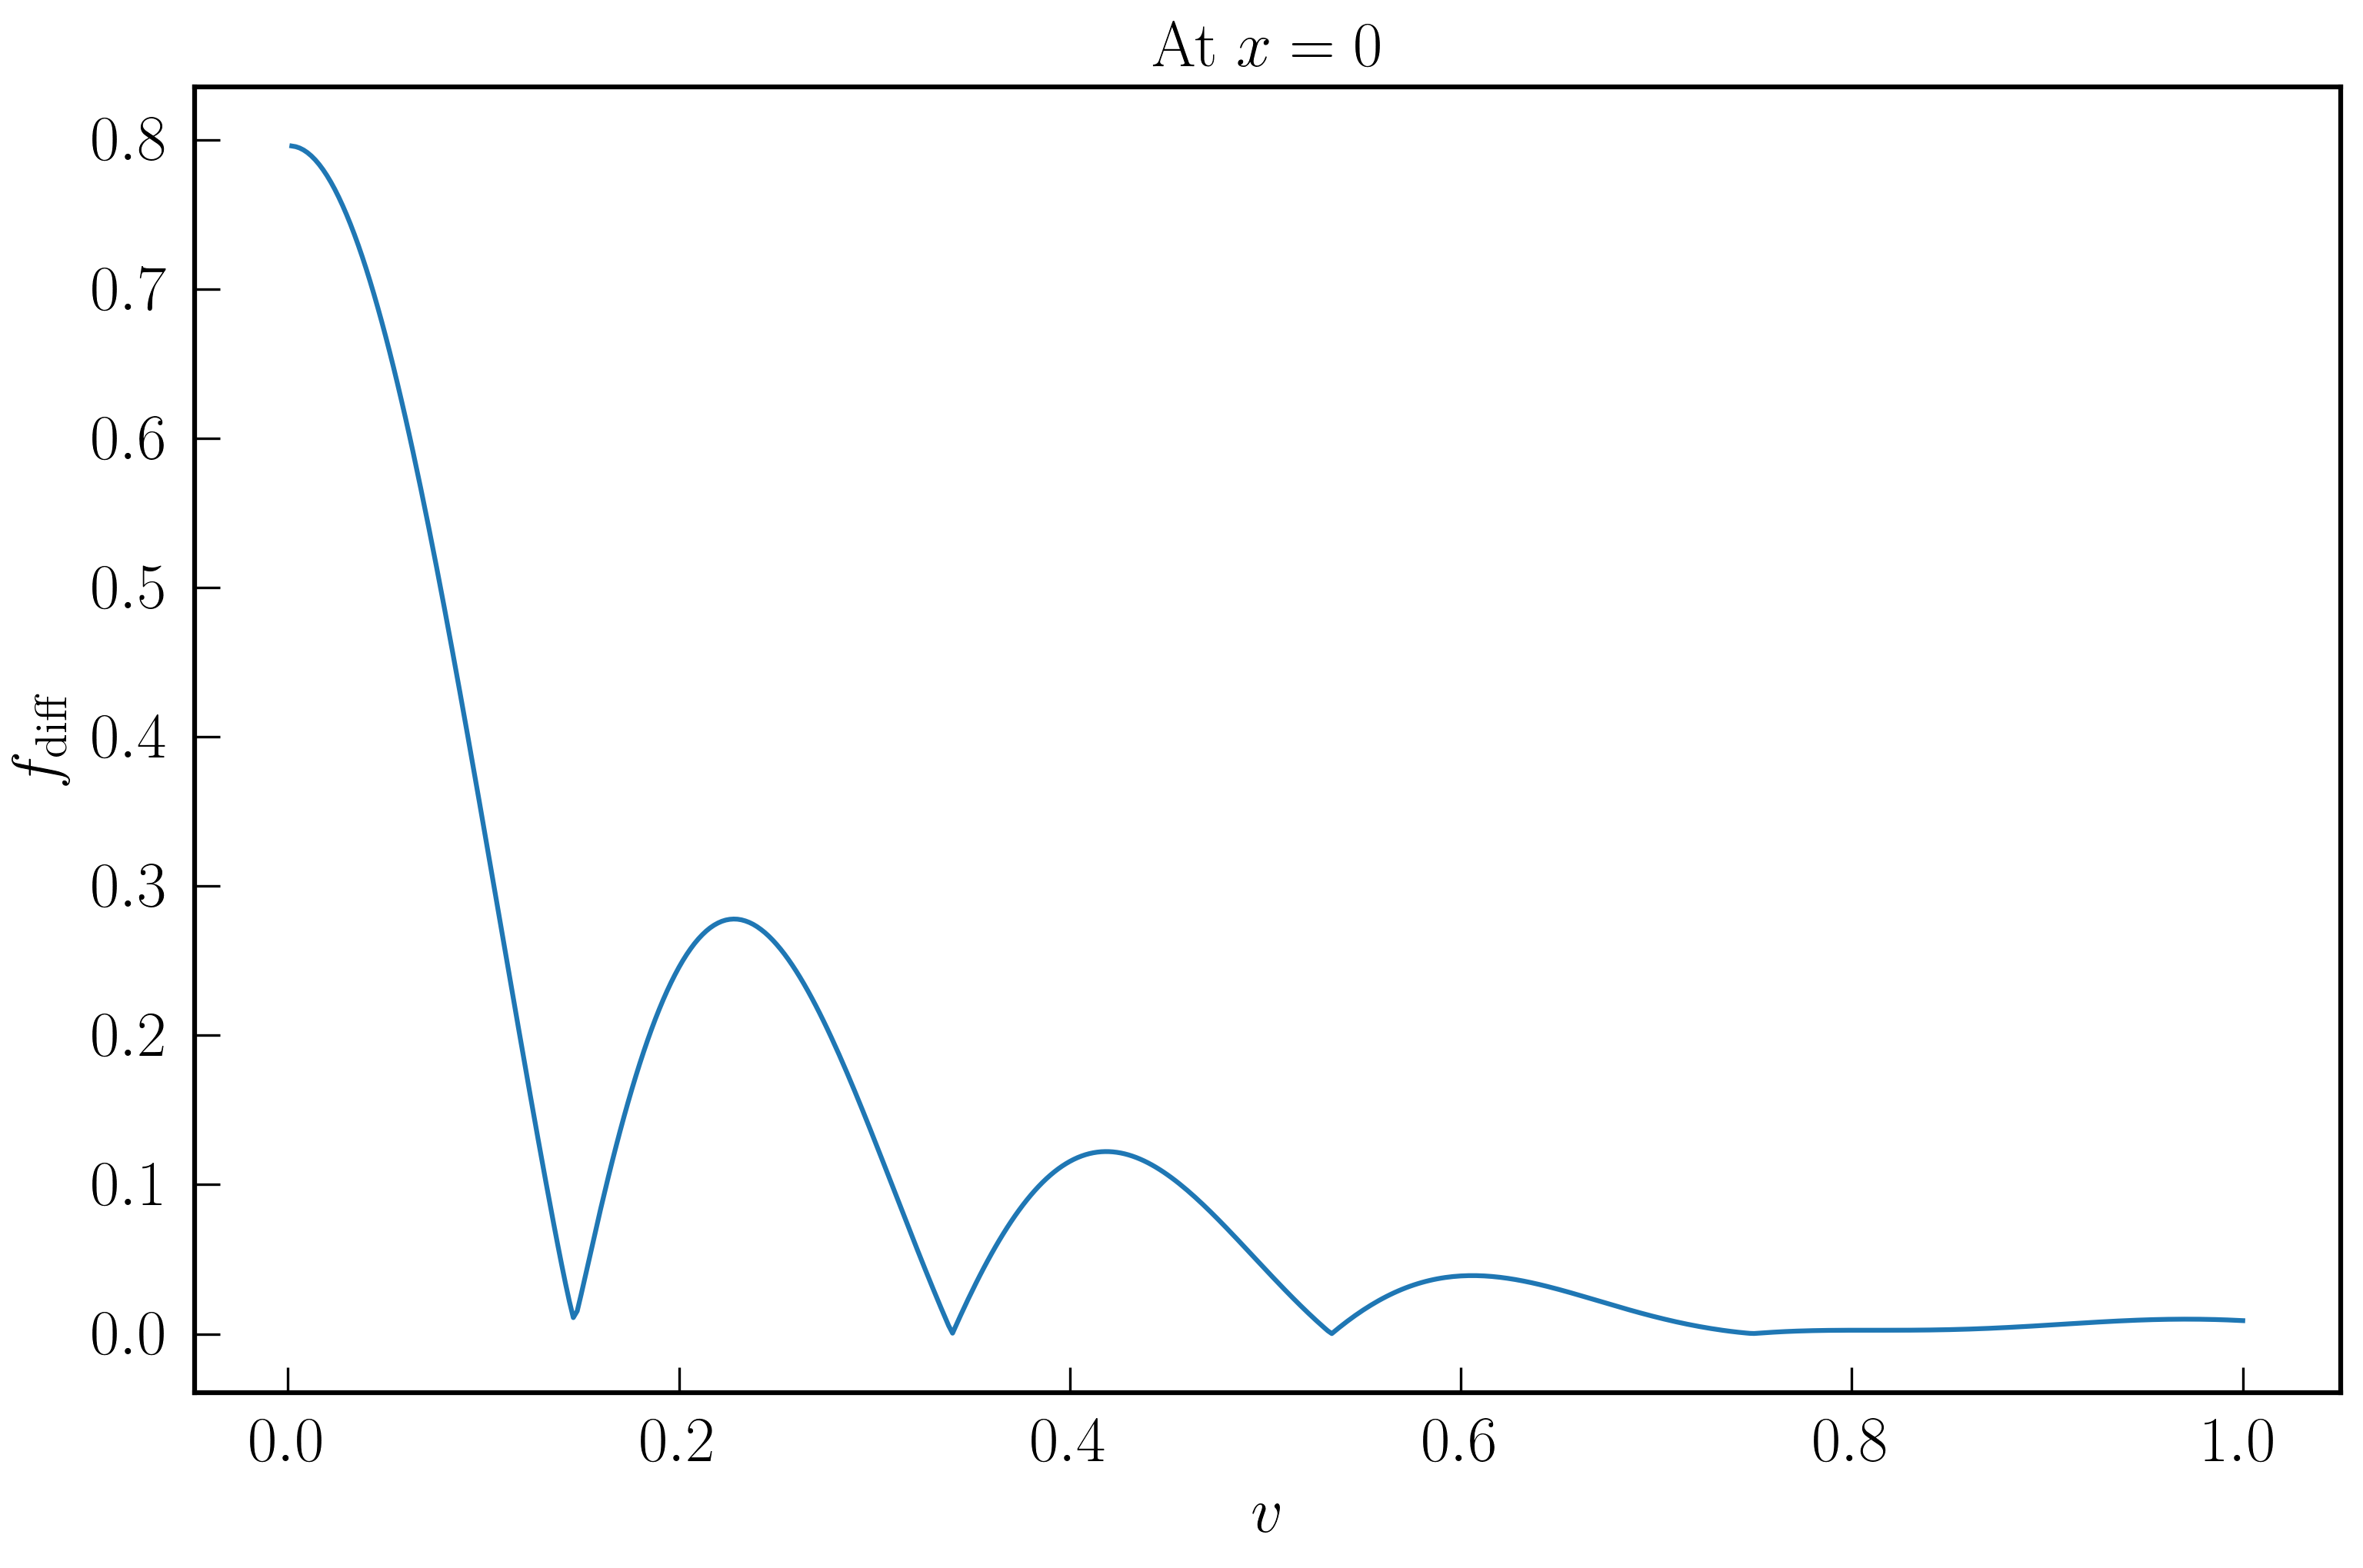

In [21]:
# f_diff = np.array(f_current[3:-3] - f_background[3:-3])
# v_pl = np.array(af.reorder(v[0]))
pl.plot(time_array, data)
pl.ylabel(r'$f_{\mathrm{diff}}$')
pl.xlabel('$v$')
pl.title(r'At $x=0$')

In [22]:
h5f = h5py.File('CK_' + str(N_positions) + '.h5', 'w')
h5f.create_dataset('max_E', data = data)
h5f.close()